# Version 2 for Infant 1 processing
1. Read the data
1. Perform interquartile range smoothing for outlier
1. Normalize the data to (-1, 1)
1. Frequency filtering for ECG and RESP - no use
1. Calculate the Heart rate (BPM) and respiration rate (BPM)
1. Correlation test
1. Linear Regression


In [429]:
# Import of libraries/modules
### -------------------------------------------
import wfdb
from wfdb import processing
### ------------------------------------------- 
import scipy
from scipy.signal import butter, lfilter, filtfilt
### -------------------------------------------
import matplotlib.pyplot as plt
### -------------------------------------------
import numpy as np
### -------------------------------------------
import pandas as pd
### -------------------------------------------
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
### -------------------------------------------
import functools
### -------------------------------------------
import seaborn as sns
### -------------------------------------------
scaler = MinMaxScaler(feature_range=(-1,1))
data_dir = "../data"

In [384]:
# Read all the data
signal_ecg_0 = wfdb.rdsamp(f"{data_dir}/infant1_ecg")
record_ecg_0 = wfdb.rdrecord(f"{data_dir}/infant1_ecg")
dataframe_ecg_0 = record_ecg_0.to_dataframe()
annotation_ecg_0 = wfdb.rdann(f"{data_dir}/infant1_ecg", 'qrsc',shift_samps=True)
signal_resp_0 = wfdb.rdsamp(f"{data_dir}/infant1_resp")
record_resp_0 = wfdb.rdrecord(f"{data_dir}/infant1_resp")
annotation_resp_0 = wfdb.rdann(f"{data_dir}/infant1_resp", 'resp',shift_samps=True)
dataframe_resp_0 = record_resp_0.to_dataframe()

In [385]:
# Some Custom Function
def startTime_num(time, fs):
    n = time * fs
    return n


def iqr_remove_outlier(x, lower, upper):
    if (x < lower):
        return lower
    elif (x > upper): 
        return upper
    else:
        return x


def correlationTest(signal_1, signal_2):
    # Inspect by scatter plot
    plt.scatter(signal_1, signal_2)
    # Covariance
    covariance = np.cov(signal_1, signal_2)
    print(covariance)
    # calculate Pearson's correlation - 0 is no correlation -1 or 1 is highly correlated
    corr, _ = scipy.stats.pearsonr(signal_1, signal_2)
    print('Pearsons correlation: %.3f' % corr)
    # calculate spearman's correlation - 0 is no correlation -1 or 1 is highly correlated
    corr, _ = scipy.stats.spearmanr(signal_1, signal_2)
    print('Spearmans correlation: %.3f' % corr)


def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


def peaks_rr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Repiration rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('RESP (NU)', color='#3979f0')
    ax_right.set_ylabel('Repiration rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()

In [386]:
# Start and end time defined
start_time_secs = 48000
end_time_secs = 50000

ECG_startNum = startTime_num(start_time_secs, record_ecg_0.fs)
ECG_endNum = startTime_num(end_time_secs, record_ecg_0.fs)

RESP_startNum = startTime_num(start_time_secs, record_resp_0.fs)
RESP_endNum = startTime_num(end_time_secs, record_resp_0.fs)

### Read data into smaller bin

In [387]:
# ECG data bin - make the data handling more convenient by reading a smaller portion of data
duration_ECG = 30000
kth_ECG = 0
# startNum_ECG = duration_ECG*kth_ECG
startNum_ECG = ECG_startNum
# endNum_ECG = duration_ECG*(kth_ECG+1)
endNum_ECG = ECG_endNum
signals_ECG = wfdb.rdsamp(f"{data_dir}/infant1_ecg", sampfrom=startNum_ECG, sampto=endNum_ECG)
record_ECG = wfdb.rdrecord(f"{data_dir}/infant1_ecg", sampfrom=startNum_ECG, sampto=endNum_ECG)
dataframe_ECG = record_ECG.to_dataframe()
annotation_ECG = wfdb.rdann(f"{data_dir}/infant1_ecg", 'qrsc', sampfrom=startNum_ECG, sampto=endNum_ECG, shift_samps=True)
startTime_seconds_ECG = startNum_ECG/record_ECG.fs
endTime_seconds_ECG = endNum_ECG/record_ECG.fs
startTime_minutes_ECG = (startTime_seconds_ECG)/60
endTime_minutes_ECG = (endTime_seconds_ECG)/60
startTime_hours_ECG = startTime_minutes_ECG/60
endTime_hours_ECG = endTime_minutes_ECG/60

In [388]:
# Generate Timestamp array
start = startTime_seconds_ECG
stop = endTime_seconds_ECG
step = 1/record_ECG.fs
time_array_seconds_ECG = np.arange(start=start, stop=stop, step=step)
time_array_minutes_ECG = time_array_seconds_ECG/60

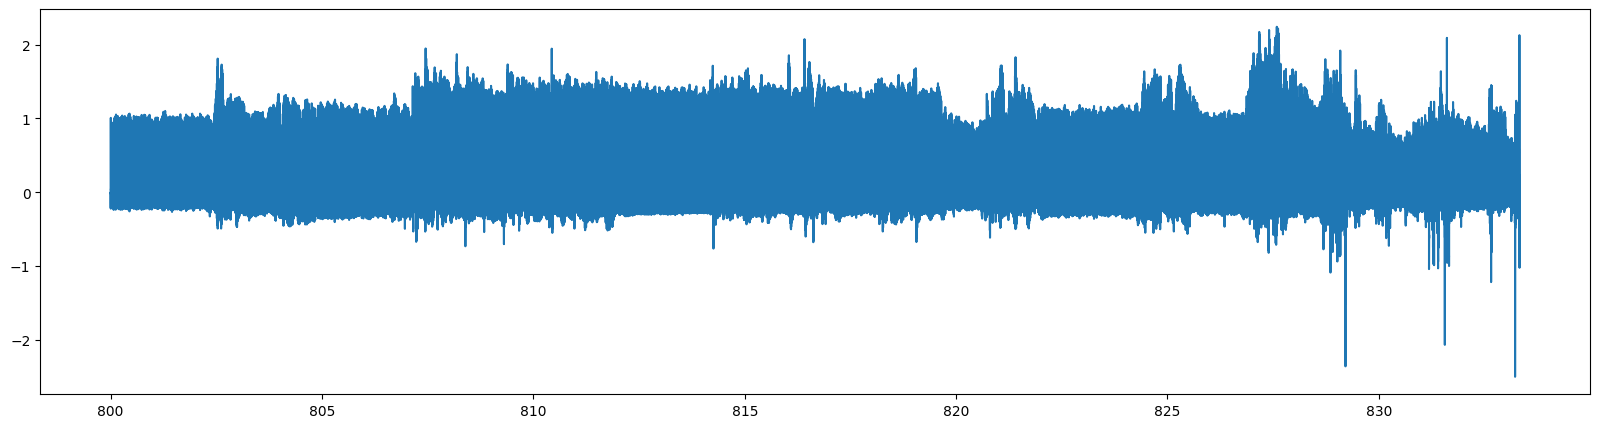

In [389]:
# Plot the ECG DATA
slice = 1
bin = int(signals_ECG[0].shape[0]/slice)
plt.figure(num=101, figsize=(20,5))
plt.plot(time_array_minutes_ECG[:bin], signals_ECG[0][:bin], label='ECG Data')

In [390]:
# RESP data bin - make the data handling more convenient by reading a smaller portion of data
duration_RESP = 60000
kth_RESP = 400
# startNum_RESP = duration_RESP*kth_RESP
startNum_RESP = RESP_startNum
# endNum_RESP = duration_RESP*(kth_RESP+1)
endNum_RESP = RESP_endNum
signals_RESP = wfdb.rdsamp(f"{data_dir}/infant1_resp", sampfrom=startNum_RESP, sampto=endNum_RESP)
record_RESP = wfdb.rdrecord(f"{data_dir}/infant1_resp", sampfrom=startNum_RESP, sampto=endNum_RESP)
dataframe_RESP = record_RESP.to_dataframe()
annotation_RESP = wfdb.rdann(f"{data_dir}/infant1_resp", 'resp', sampfrom=startNum_RESP, sampto=endNum_RESP, shift_samps=True)
startTime_seconds_RESP = startNum_RESP/record_RESP.fs
endTime_seconds_RESP = endNum_RESP/record_RESP.fs
startTime_minutes_RESP = (startTime_seconds_RESP)/60
endTime_minutes_RESP = (endTime_seconds_RESP)/60
startTime_hours_RESP = startTime_minutes_RESP/60
endTime_hours_RESP = endTime_minutes_RESP/60

In [391]:
# Generate Timestamp array
start = startTime_seconds_RESP
stop = endTime_seconds_RESP
step = 1/record_RESP.fs
time_array_seconds_RESP = np.arange(start=start, stop=stop, step=step)
time_array_minutes_RESP = time_array_seconds_RESP/60

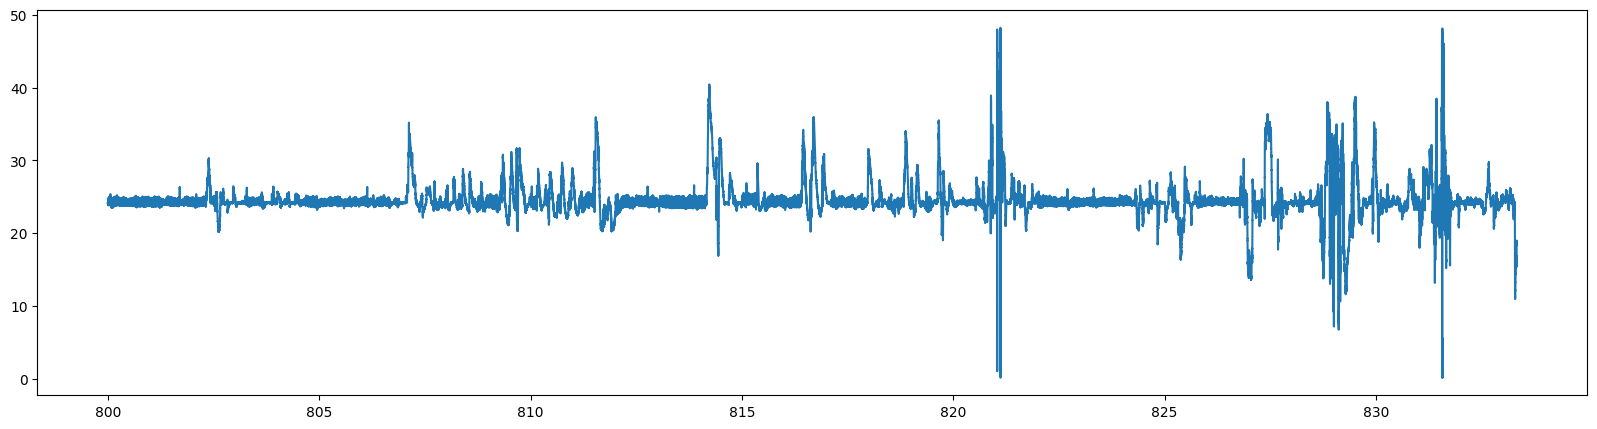

In [392]:
# Plot the RESP DATA
slice = 1
bin = int(signals_RESP[0].shape[0]/slice)
plt.figure(num=102, figsize=(20,5))
plt.plot(time_array_minutes_RESP[:bin], signals_RESP[0][:bin], label='RESP Data')

### Remove outlier with IQR

In [393]:
# ECG DATA - Description with IQR
print("ECG DATA")
print("-----------------------------------------------------------------------------------")
print(signals_ECG[1])
print(signals_ECG[0].shape)
print(f"Start time: {startTime_seconds_ECG} seconds, End time: {endTime_seconds_ECG} seconds")
print(f"Start time: {startTime_minutes_ECG} minutes, End time: {endTime_minutes_ECG} minutes")
print(f"Start time: {startTime_hours_ECG} hours, End time: {endTime_hours_ECG} hours")
print(dataframe_ECG.describe())
q75_ECG, q25_ECG = np.percentile(signals_ECG[0], [75, 27])
q90_ECG, q10_ECG = np.percentile(signals_ECG[0], [90, 10])
q95_ECG, q5_ECG = np.percentile(signals_ECG[0], [95, 5])
print(f"25th percentile: {q25_ECG}, 75th percentile: {q75_ECG}")
print(f"10th percentile: {q10_ECG}, 90th percentile: {q90_ECG}")
print(f"5th percentile: {q5_ECG}, 95th percentile: {q95_ECG}")

ECG DATA
-----------------------------------------------------------------------------------
{'fs': 250, 'sig_len': 500000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['ECG'], 'comments': []}
(500000, 1)
Start time: 48000.0 seconds, End time: 50000.0 seconds
Start time: 800.0 minutes, End time: 833.3333333333334 minutes
Start time: 13.333333333333334 hours, End time: 13.88888888888889 hours
                 ECG
count  500000.000000
mean       -0.028422
std         0.240230
min        -2.495442
25%        -0.139885
50%        -0.059951
75%         0.009992
max         2.240652
25th percentile: -0.1298928870779933, 75th percentile: 0.009991760544461024
10th percentile: -0.2110759415017391, 90th percentile: 0.0761871741515153
5th percentile: -0.2647816544282171, 95th percentile: 0.3397198585116748


In [394]:
# RESP DATA - Description with IQR 
print("RESP DATA")
print("-----------------------------------------------------------------------------------")
print(signals_RESP[1])
print(signals_RESP[0].shape)
print(f"Start time: {startTime_seconds_RESP} seconds, End time: {endTime_seconds_RESP} seconds")
print(f"Start time: {startTime_minutes_RESP} minutes, End time: {endTime_minutes_RESP} minutes")
print(f"Start time: {startTime_hours_RESP} hours, End time: {endTime_hours_RESP} hours")
print(dataframe_RESP.describe())
q75_RESP, q25_RESP = np.percentile(signals_RESP[0], [75, 27])
q90_RESP, q10_RESP = np.percentile(signals_RESP[0], [90, 10])
q95_RESP, q5_RESP = np.percentile(signals_RESP[0], [95, 5])
print(f"25th percentile: {q25_RESP}, 75th percentile: {q75_RESP}")
print(f"10th percentile: {q10_RESP}, 90th percentile: {q90_RESP}")
print(f"5th percentile: {q5_RESP}, 95th percentile: {q95_RESP}")

RESP DATA
-----------------------------------------------------------------------------------
{'fs': 500, 'sig_len': 1000000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['NU'], 'sig_name': ['RESP'], 'comments': []}
(1000000, 1)
Start time: 48000.0 seconds, End time: 50000.0 seconds
Start time: 800.0 minutes, End time: 833.3333333333334 minutes
Start time: 13.333333333333334 hours, End time: 13.88888888888889 hours
                 RESP
count  1000000.000000
mean        24.553035
std          2.562442
min          0.120848
25%         23.844437
50%         24.177143
75%         24.739611
max         48.230455
25th percentile: 23.886958090887408, 75th percentile: 24.739610821841605
10th percentile: 23.22751363405144, 90th percentile: 26.5806842601574
5th percentile: 22.098849082928346, 95th percentile: 28.854424876035257


In [395]:
# Interquartile 
iqr1_ECG = q75_ECG-q25_ECG
iqr2_ECG = q90_ECG-q10_ECG
iqr3_ECG = q95_ECG-q5_ECG
decimal_ECG = 3
print(f"ECG")
print(f"Percentiles: 25th={q25_ECG:.{decimal_ECG}f}, 75th={q75_ECG:.{decimal_ECG}f}, IQR={iqr1_ECG:.{decimal_ECG}f}")
print(f"Percentiles: 10th={q10_ECG:.{decimal_ECG}f}, 90th={q90_ECG:.{decimal_ECG}f}, IQR={iqr2_ECG:.{decimal_ECG}f}")
print(f"Percentiles: 5th={q5_ECG:.{decimal_ECG}f}, 95th={q95_ECG:.{decimal_ECG}f}, IQR={iqr3_ECG:.{decimal_ECG}f}")
print("--------------------------------")
iqr1_RESP = q75_RESP-q25_RESP
iqr2_RESP = q90_RESP-q10_RESP
iqr3_RESP = q95_RESP-q5_RESP
decimal_RESP = 3
print(f"RESP")
print(f"Percentiles: 25th={q25_RESP:.{decimal_RESP}f}, 75th={q75_RESP:.{decimal_RESP}f}, IQR={iqr1_RESP:.{decimal_RESP}f}")
print(f"Percentiles: 10th={q10_RESP:.{decimal_RESP}f}, 90th={q90_RESP:.{decimal_RESP}f}, IQR={iqr2_RESP:.{decimal_RESP}f}")
print(f"Percentiles: 5th={q5_RESP:.{decimal_RESP}f}, 95th={q95_RESP:.{decimal_RESP}f}, IQR={iqr3_RESP:.{decimal_RESP}f}")

ECG
Percentiles: 25th=-0.130, 75th=0.010, IQR=0.140
Percentiles: 10th=-0.211, 90th=0.076, IQR=0.287
Percentiles: 5th=-0.265, 95th=0.340, IQR=0.605
--------------------------------
RESP
Percentiles: 25th=23.887, 75th=24.740, IQR=0.853
Percentiles: 10th=23.228, 90th=26.581, IQR=3.353
Percentiles: 5th=22.099, 95th=28.854, IQR=6.756


In [396]:
# ECG DATA - Remove Outlier
# calculate the outlier cutoff
print("ECG DATA")
cut_off_ECG = iqr1_ECG * 1.5
lower_ECG, upper_ECG = q25_ECG - cut_off_ECG, q75_ECG + cut_off_ECG
# identify outliers
signals_ECG_outliers = [x for x in signals_ECG[0] if x < lower_ECG or x > upper_ECG]
print('Identified outliers: %d' % len(signals_ECG_outliers))
signals_ECG_1 = []
signals_ECG_1 = map(functools.partial(iqr_remove_outlier, lower=lower_ECG, upper=upper_ECG), signals_ECG[0])
print(signals_ECG_1)
signals_ECG_1 = np.fromiter(signals_ECG_1, dtype=np.float64)
print(f"ECG Data Shape: {signals_ECG_1.shape}")
print(signals_ECG_1)

ECG DATA
Identified outliers: 37640
ECG Data Shape: (500000,)
[-0.00999176 -0.00999176 -0.00749382 ...  0.05120777  0.02123249
 -0.00374691]


In [397]:
# RESP DATA - Remove Outlier
# calculate the outlier cutoff
print("RESP DATA")
cut_off_RESP = iqr1_RESP * 1
lower_RESP, upper_RESP = q25_RESP - cut_off_RESP, q75_RESP + cut_off_RESP
# identify outliers
signals_RESP_outliers = [x for x in signals_RESP[0] if x < lower_RESP or x > upper_RESP]
print('Identified outliers: %d' % len(signals_ECG_outliers))
signals_RESP_1 =[]
signals_RESP_1 = map(functools.partial(iqr_remove_outlier, lower=lower_RESP, upper=upper_RESP), signals_RESP[0])
print(signals_RESP_1)
signals_RESP_1 = np.fromiter(signals_RESP_1, dtype=np.float64)
print(f"RESP Data Shape: {signals_RESP_1.shape}")
print(signals_RESP_1)

RESP DATA
Identified outliers: 37640
RESP Data Shape: (1000000,)
[24.22264814 24.2241401  24.22115619 ... 23.03430536 23.03430536
 23.03430536]


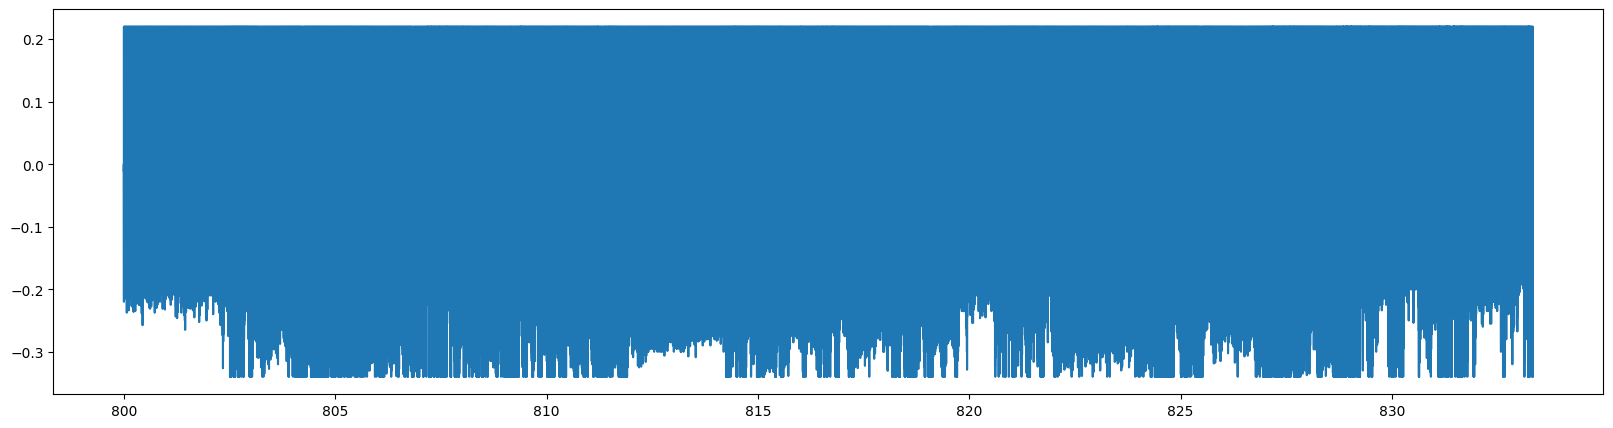

In [398]:
# Plot the ECG DATA
slice = 1
bin = int(signals_ECG_1.shape[0]/slice)
plt.figure(num=201, figsize=(20,5))
plt.plot(time_array_minutes_ECG[:bin], signals_ECG_1[:bin], label='ECG Data')

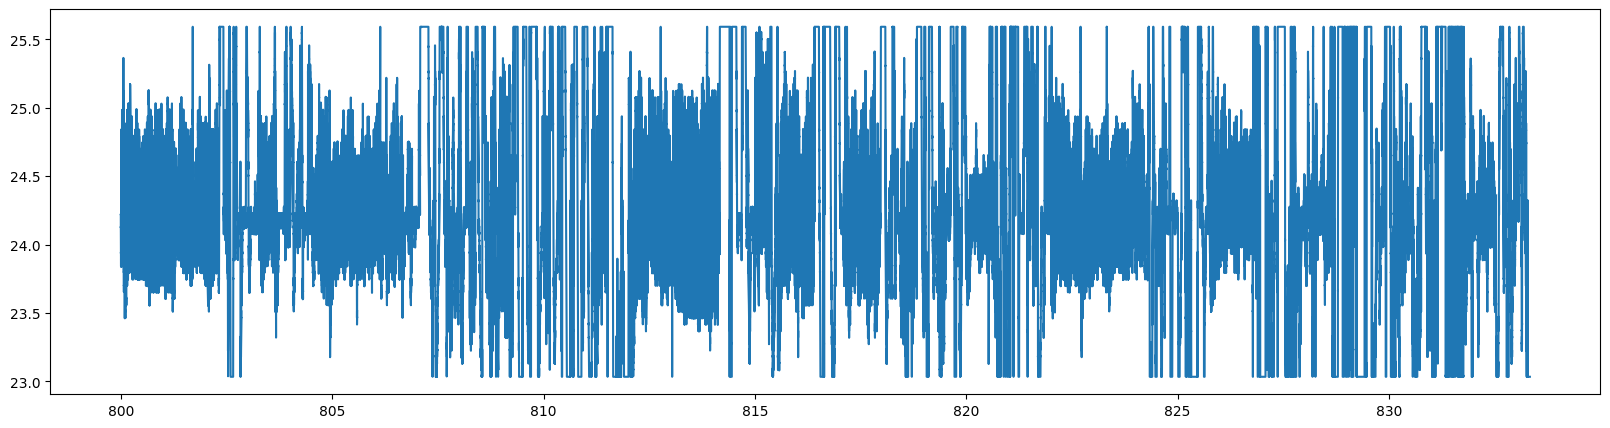

In [399]:
# Plot the RESP DATA
slice = 1
bin = int(signals_RESP_1.shape[0]/slice)
plt.figure(num=202, figsize=(20,5))
plt.plot(time_array_minutes_RESP[:bin], signals_RESP_1[:bin], label='RESP Data')

### Normalize data to (-1,1)

In [400]:
# Reshape the data
print(signals_ECG_1.shape)
signals_ECG_2 = signals_ECG_1.reshape(signals_ECG_1.shape[0],1)
print(signals_ECG_2.shape)
print(signals_RESP_1.shape)
signals_RESP_2 = signals_RESP_1.reshape(signals_RESP_1.shape[0],1)
print(signals_RESP_2.shape)

(500000,)
(500000, 1)
(1000000,)
(1000000, 1)


In [401]:
# Normalization
signals_ECG_3 = scaler.fit_transform(signals_ECG_2)
signals_RESP_3 = scaler.fit_transform(signals_RESP_2)

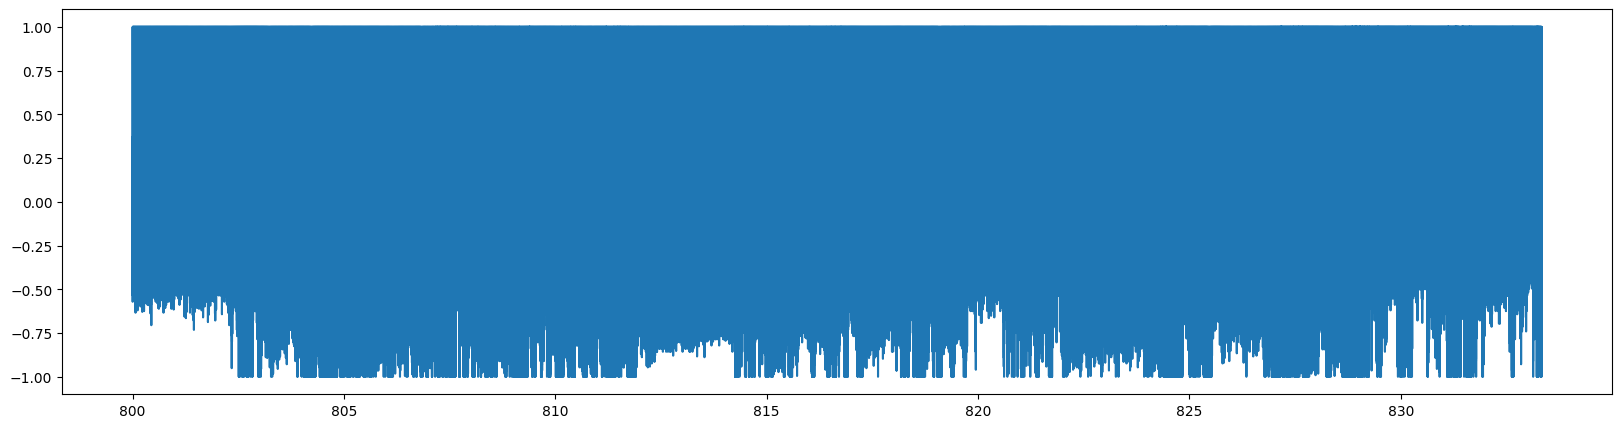

In [402]:
# Plot the ECG DATA
slice = 1
bin = int(signals_ECG_3.shape[0]/slice)
plt.figure(num=301, figsize=(20,5))
plt.plot(time_array_minutes_ECG[:bin], signals_ECG_3[:bin], label='ECG Data')

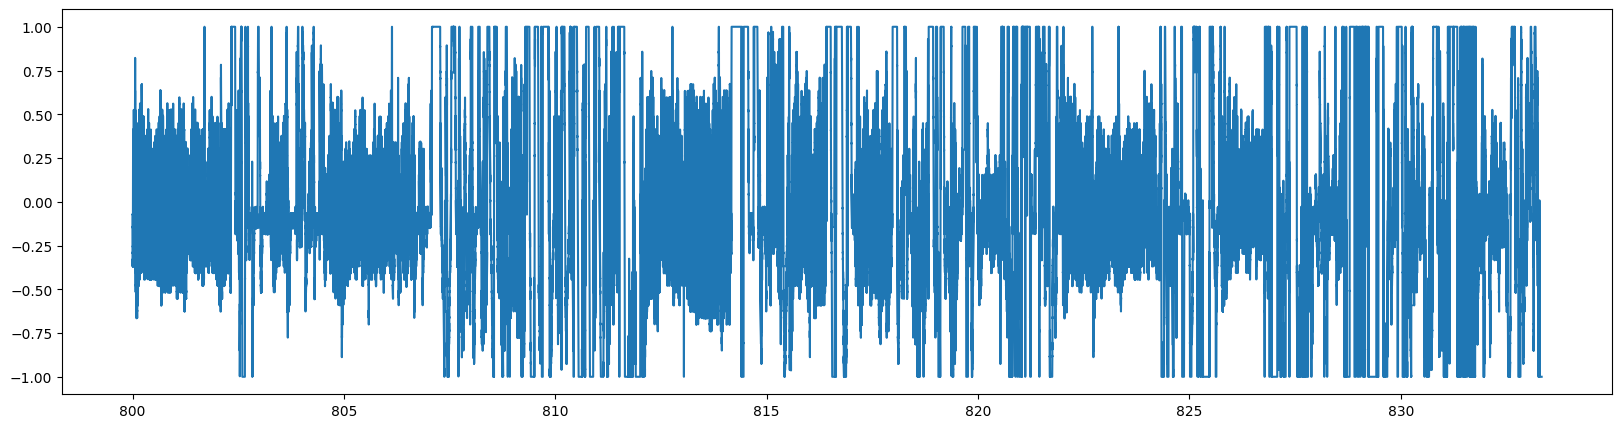

In [403]:
# Plot the RESP DATA
slice = 1
bin = int(signals_RESP_3.shape[0]/slice)
plt.figure(num=302, figsize=(20,5))
plt.plot(time_array_minutes_RESP[:bin], signals_RESP_3[:bin], label='RESP Data')

### Fast Fourier Transform

In [404]:
# Reshape the Data
signals_ECG_4 = signals_ECG_3.reshape(signals_ECG_3.shape[0])
signals_RESP_4 = signals_RESP_3.reshape(signals_RESP_3.shape[0])

In [405]:
# FFT
yf_ECG_1 = scipy.fft.fft(signals_ECG_4)
xf_ECG_1 = scipy.fft.fftfreq(signals_ECG_4.shape[0], 1/record_ECG.fs)
yf_RESP_1 = scipy.fft.fft(signals_RESP_4)
xf_RESP_1 = scipy.fft.fftfreq(signals_RESP_4.shape[0], 1/record_RESP.fs)

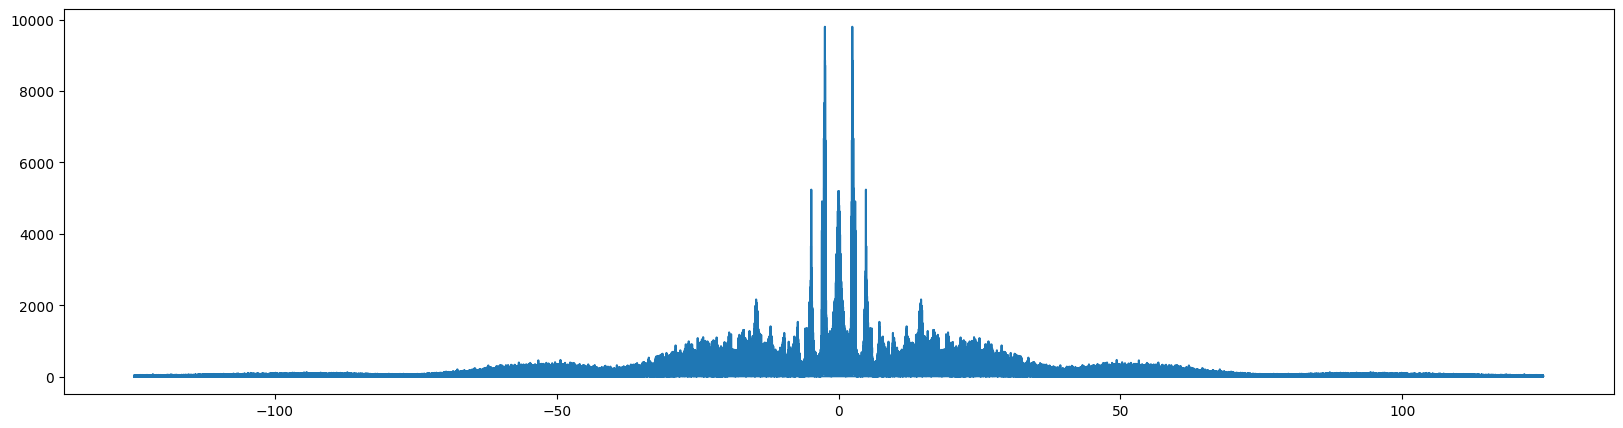

In [406]:
# Plot Frequency Based ECG DATA
slice = 1
bin = int(xf_ECG_1.shape[0]/slice)
plt.figure(num=401,figsize=(20,5))
plt.plot(xf_ECG_1[:bin], np.abs(yf_ECG_1[:bin]))

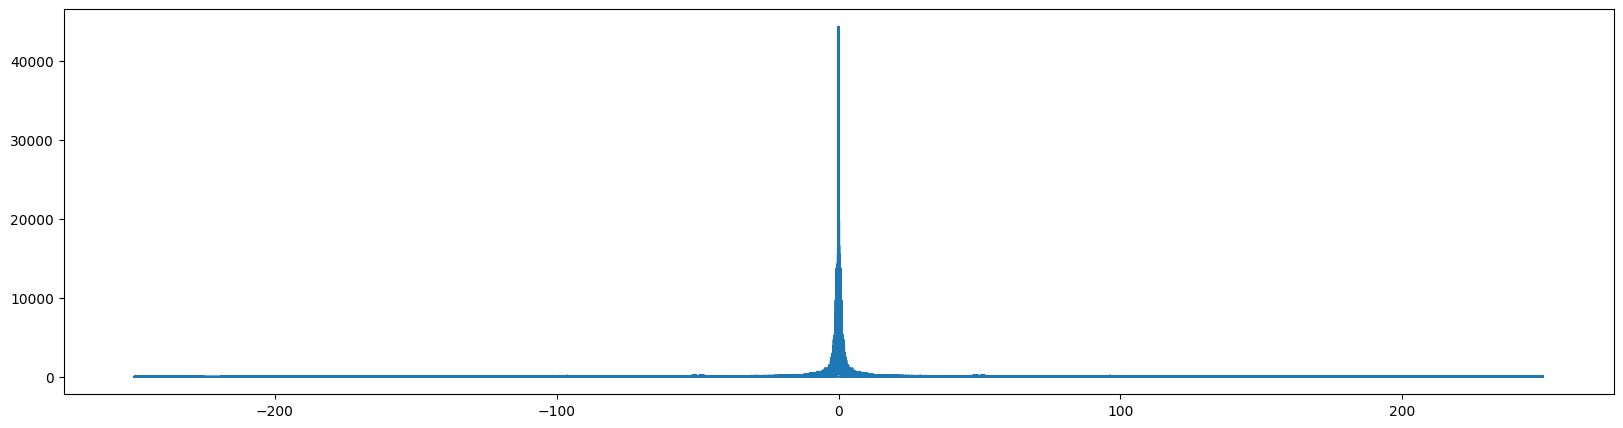

In [407]:
# Plot Frequency Based RESP DATA
slice = 1
bin = int(xf_RESP_1.shape[0]/slice)
plt.figure(num=402,figsize=(20,5))
plt.plot(xf_RESP_1[:bin], np.abs(yf_RESP_1[:bin]))

### Frequency Filtering
1. Bandpass
1. Lowpass
1. Highpass

In [408]:
# ECG DATA - Butterworth Bandpass - (8, 20) Hz
fs_ECG_1 = record_ECG.fs
lowcut_ECG_1 = fs_ECG_1/20
highcut_ECG_1 = fs_ECG_1/16
bandpass_order_1 = 2

signals_ECG_5 = butter_bandpass_filter(data=signals_ECG_3,lowcut=lowcut_ECG_1,highcut=highcut_ECG_1,fs=fs_ECG_1,order=bandpass_order_1)

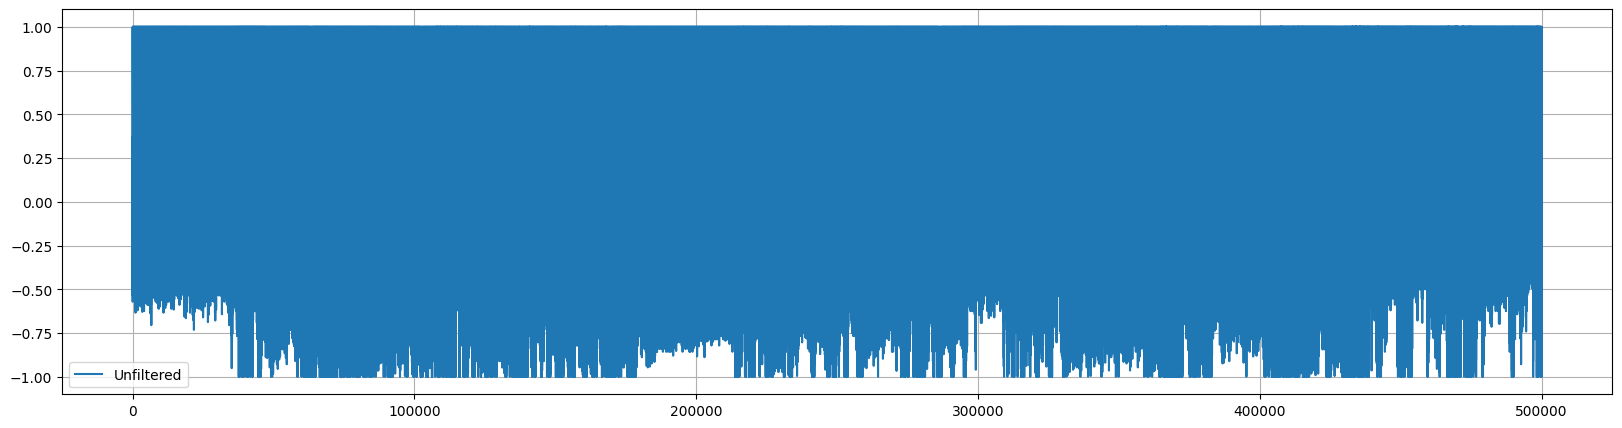

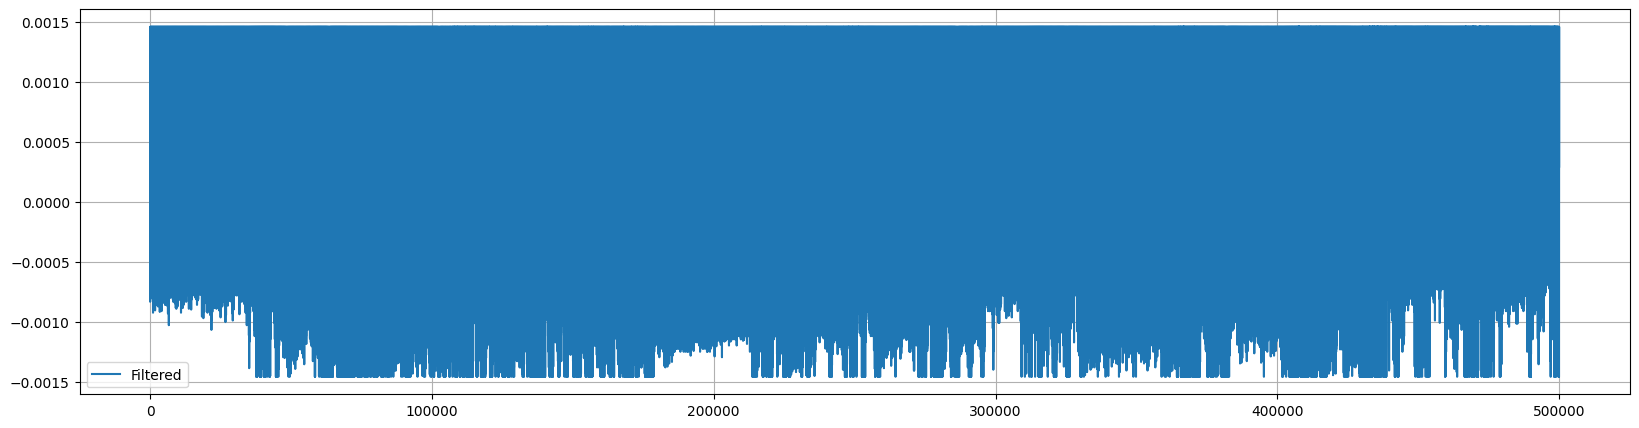

In [409]:
slice = 1
bin = int(signals_ECG_3.shape[0]/slice)
plt.figure(num=501, figsize=(20,5))
plt.plot(signals_ECG_3[:bin], label='Unfiltered')
plt.legend()
plt.grid(True)

plt.figure(num=502, figsize=(20,5))
plt.plot(signals_ECG_5[:bin], label='Filtered')
plt.legend()
plt.grid(True)

In [410]:
# ECG DATA - Lowpass Filter - cutoff frequency 20 Hz
fs_ECG_1 = record_ECG.fs
lowpass_cut_ECG_1 = fs_ECG_1/5
lowpass_order_ECG_1 = 2

signals_ECG_6 = butter_lowpass_filter(data=signals_ECG_3, cutoff=lowpass_cut_ECG_1, fs=fs_ECG_1, order=lowpass_order_ECG_1)

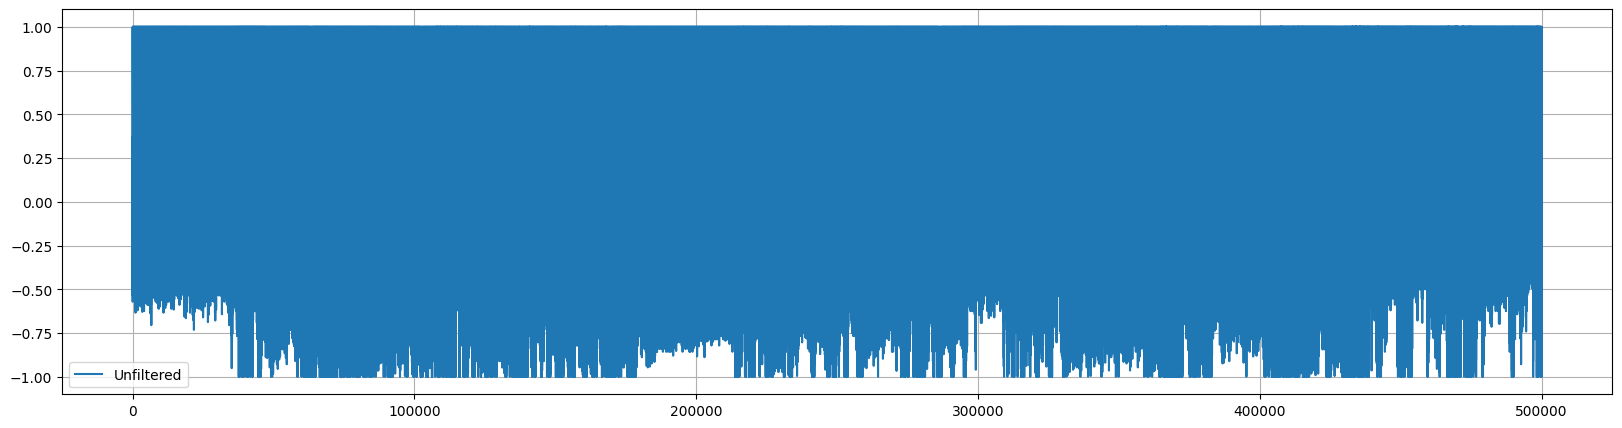

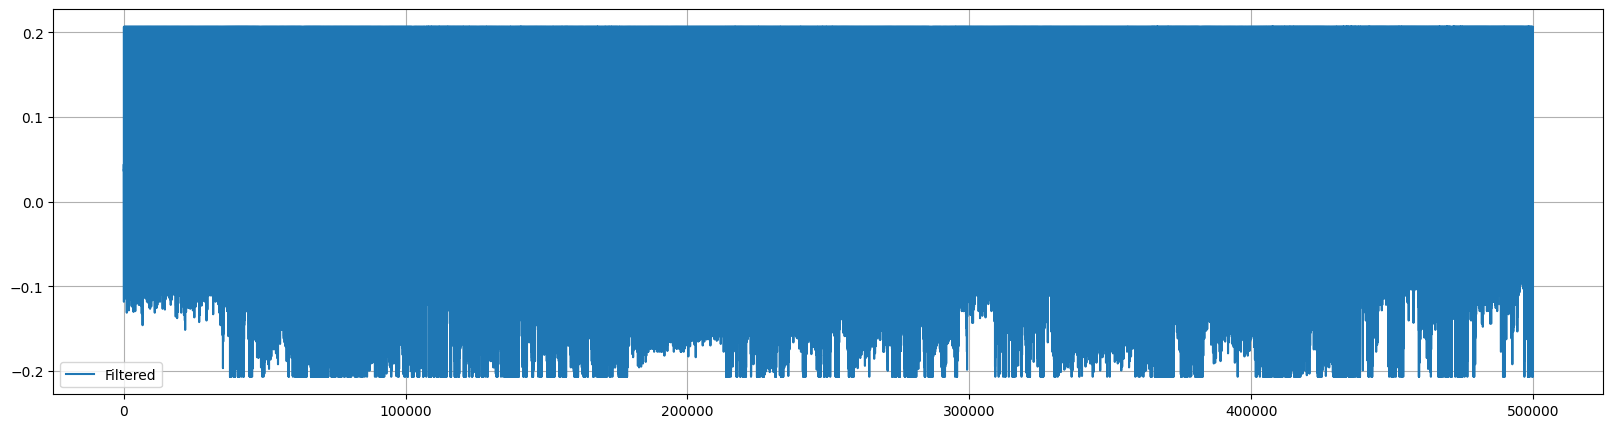

In [411]:
slice = 1
bin = int(signals_ECG_3.shape[0]/slice)
plt.figure(num=501, figsize=(20,5))
plt.plot(signals_ECG_3[:bin], label='Unfiltered')
plt.legend()
plt.grid(True)

plt.figure(num=502, figsize=(20,5))
plt.plot(signals_ECG_6[:bin], label='Filtered')
plt.legend()
plt.grid(True)

In [412]:
# RESP DATA - Butterworth Bandpass - (8, 20) Hz
fs_RESP_1 = record_RESP.fs
lowcut_RESP_1 = fs_RESP_1/20
highcut_RESP_1 = fs_RESP_1/5

signals_RESP_5 = butter_bandpass_filter(data=signals_RESP_3, lowcut=lowcut_RESP_1, highcut=highcut_RESP_1, fs=fs_RESP_1, order=6)

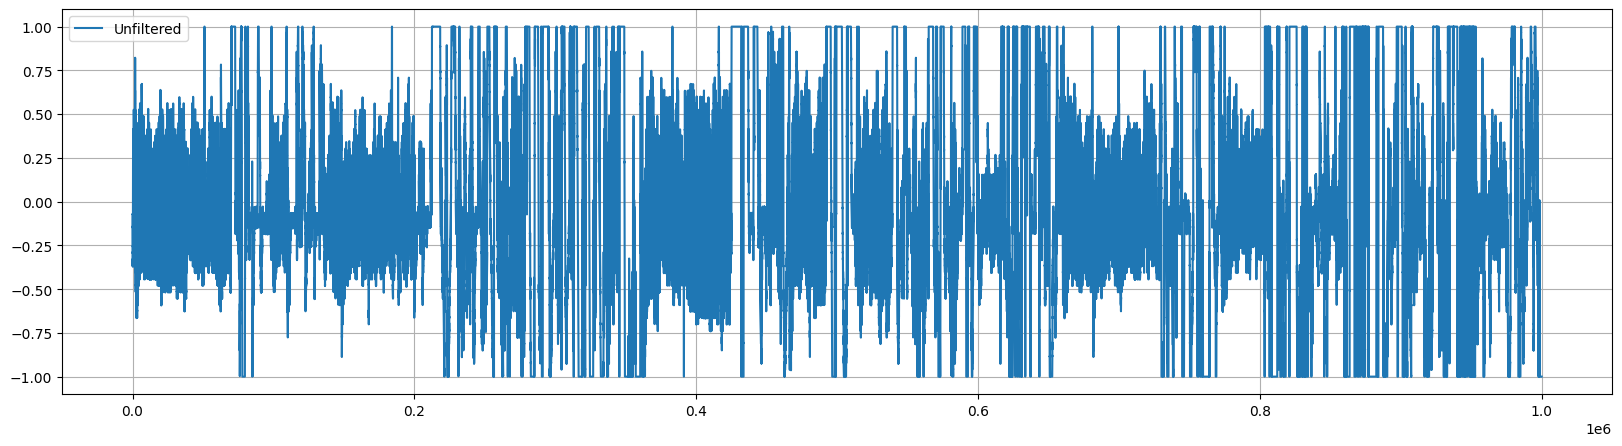

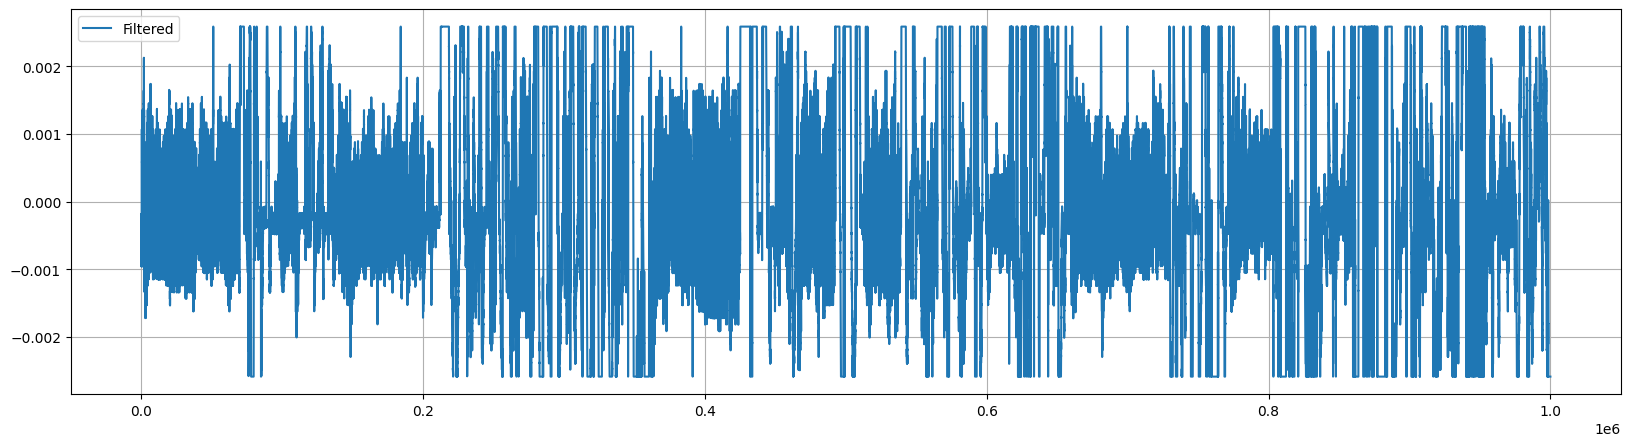

In [413]:
slice = 1
bin = int(signals_RESP_3.shape[0]/slice)
plt.figure(num=501, figsize=(20,5))
plt.plot(signals_RESP_3[:bin], label='Unfiltered')
# plt.plot(signals_RESP_5[:bin], label='Filtered')
plt.legend()
plt.grid(True)

plt.figure(num=502, figsize=(20,5))
plt.plot(signals_RESP_5[:bin], label='Filtered')
plt.legend()
plt.grid(True)

In [414]:
# RESP DATA - Lowpass Filter - cutoff frequency 20 Hz
fs_RESP_1 = record_RESP.fs
lowpass_cut_RESP_1 = 50
lowpass_order_RESP_1 = 5

signals_RESP_6 = butter_lowpass_filter(data=signals_RESP_3, cutoff=lowpass_cut_RESP_1, fs=fs_RESP_1, order=lowpass_order_RESP_1)

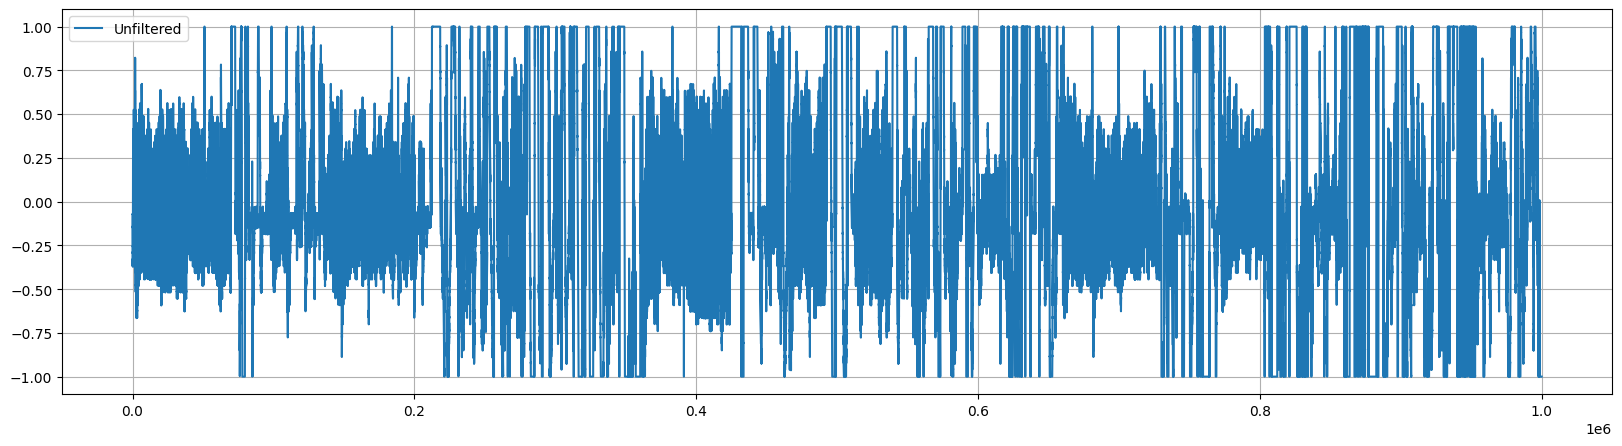

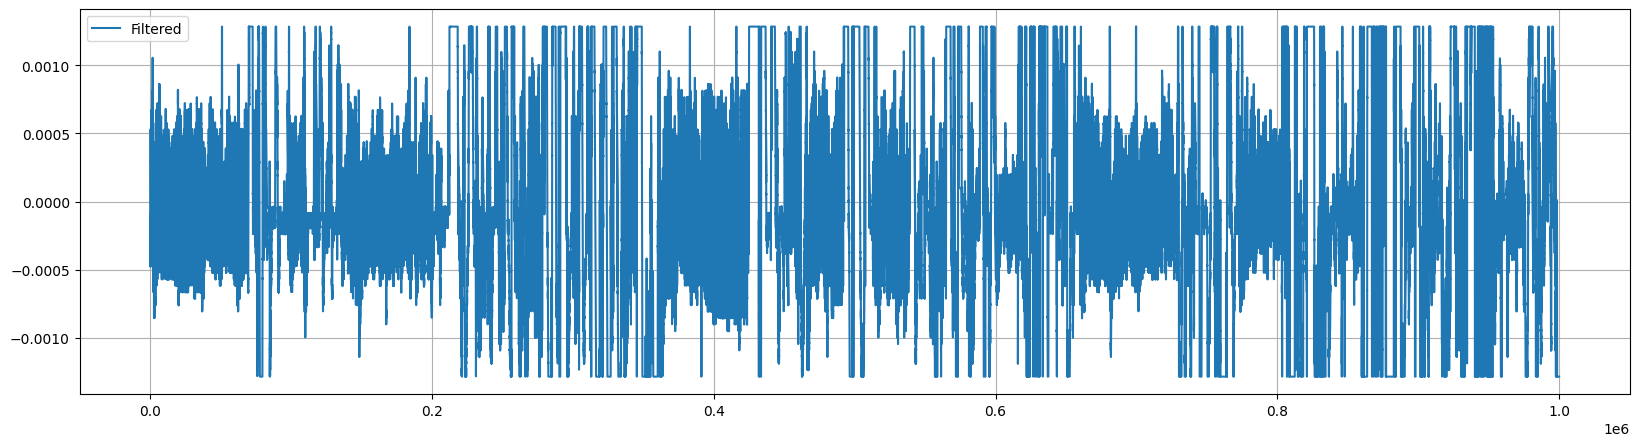

In [415]:
slice = 1
bin = int(signals_RESP_3.shape[0]/slice)
plt.figure(num=501, figsize=(20,5))
plt.plot(signals_RESP_3[:], label='Unfiltered')
plt.legend()
plt.grid(True)

plt.figure(num=502, figsize=(20,5))
plt.plot(signals_RESP_6[:], label='Filtered')
plt.legend()
plt.grid(True)

# Heart Rate and Respiration Rate

C:\Users\Justin Chong\AppData\Local\Temp\ipykernel_14468\3273009855.py:41: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx" (-> marker='x'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x',
C:\Users\Justin Chong\AppData\Local\Temp\ipykernel_14468\3273009855.py:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x',


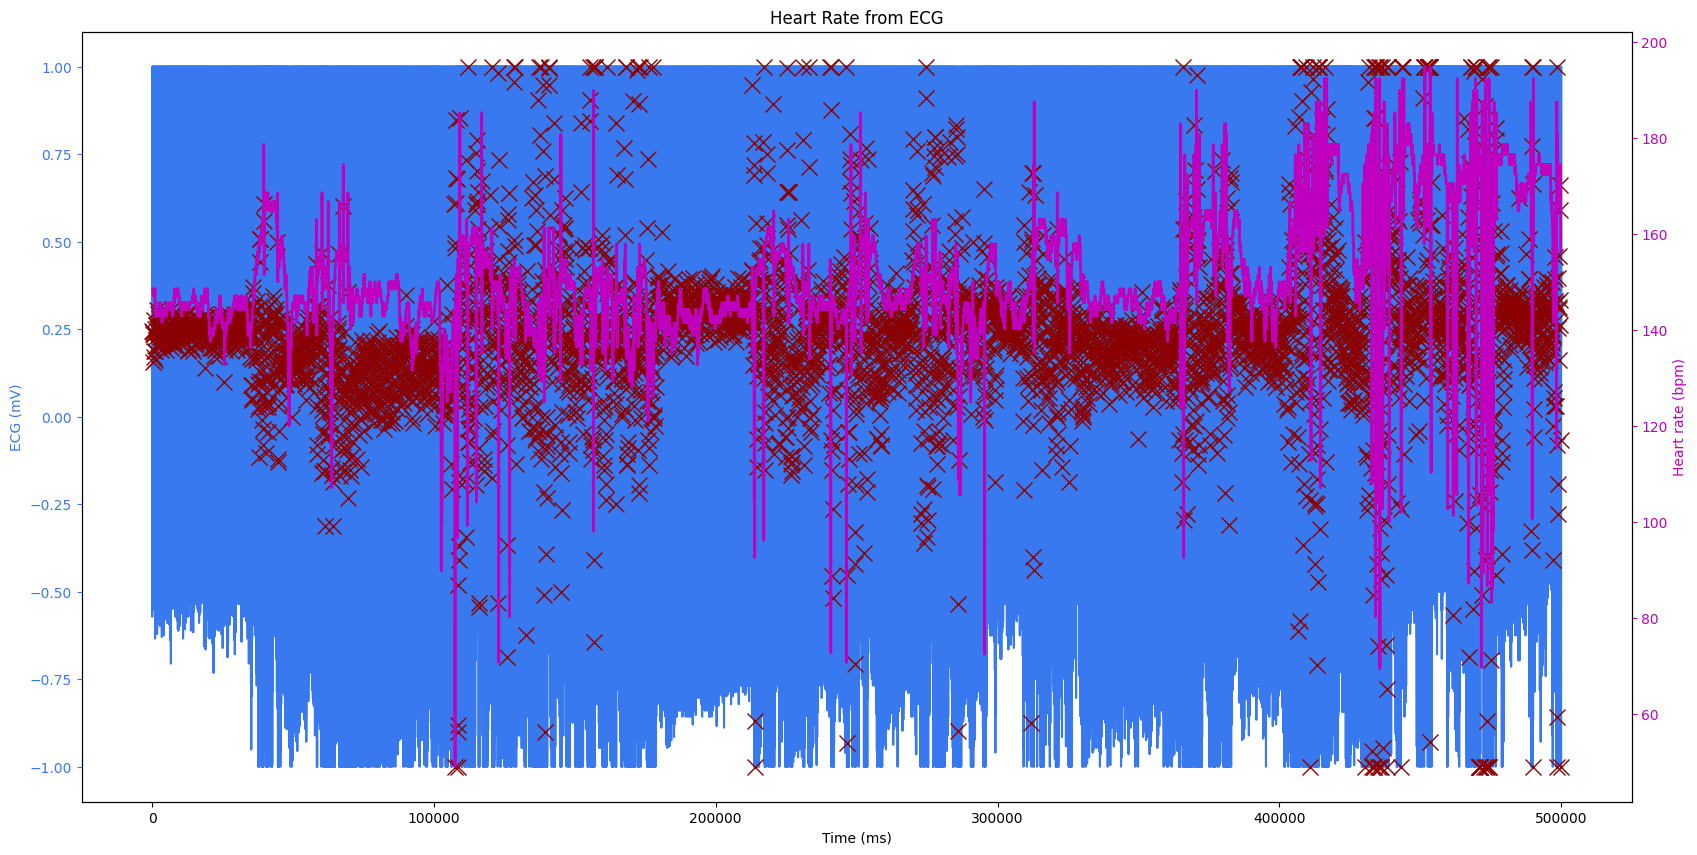

In [416]:
ECG_qrs_inds_1 = processing.qrs.gqrs_detect(sig=signals_ECG_3, fs=record_ECG.fs)
peaks_hr(sig=signals_ECG_3, peak_inds=ECG_qrs_inds_1, fs=record_ECG.fs, title="Heart Rate from ECG")

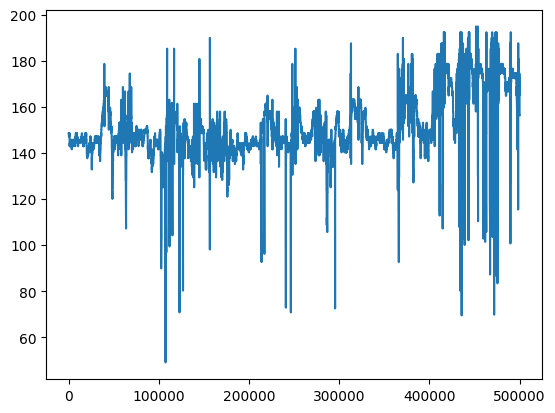

In [417]:
ECG_hrs_1 = processing.hr.compute_hr(sig_len=signals_ECG_3.shape[0], qrs_inds=ECG_qrs_inds_1, fs=record_ECG.fs)
plt.plot(ECG_hrs_1)

C:\Users\Justin Chong\AppData\Local\Temp\ipykernel_14468\3273009855.py:109: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx" (-> marker='x'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x',
C:\Users\Justin Chong\AppData\Local\Temp\ipykernel_14468\3273009855.py:109: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x',


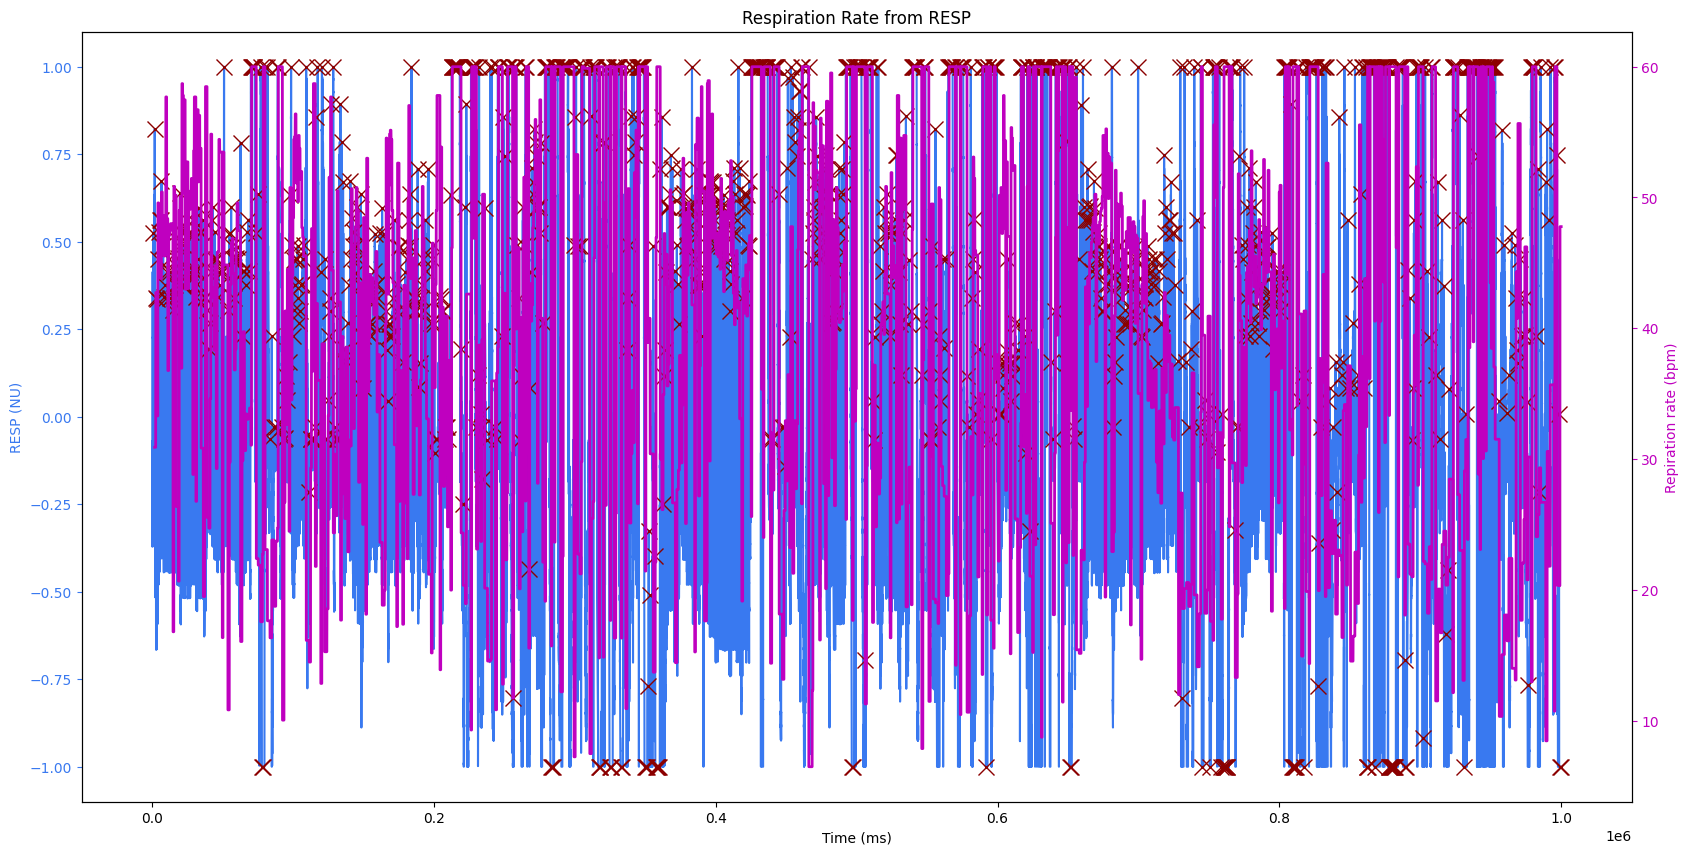

In [418]:
RESP_peak_inds_1 = processing.peaks.find_local_peaks(sig=signals_RESP_3, radius=record_RESP.fs)
peaks_rr(sig=signals_RESP_3, peak_inds=RESP_peak_inds_1, fs=record_RESP.fs, title="Respiration Rate from RESP")

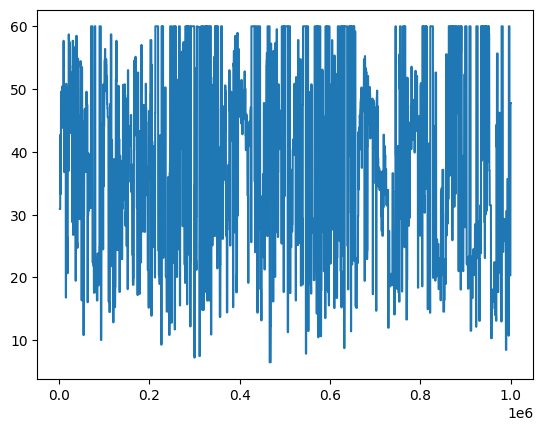

In [419]:
RESP_rrs_1 = processing.hr.compute_hr(sig_len=signals_RESP_3.shape[0], qrs_inds=RESP_peak_inds_1, fs=record_RESP.fs)
plt.plot(RESP_rrs_1)

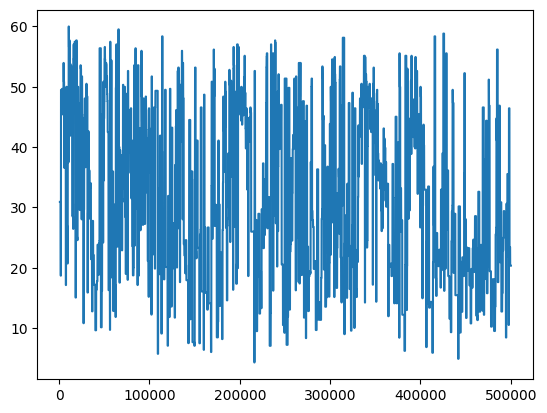

In [420]:
signals_RESP_7 = scipy.signal.resample(signals_RESP_3, signals_ECG_3.shape[0])
RESP_peak_inds_2 = processing.peaks.find_local_peaks(sig=signals_RESP_7, radius=record_ECG.fs)
RESP_rrs_2 = processing.hr.compute_hr(sig_len=signals_RESP_7.shape[0], qrs_inds=RESP_peak_inds_2, fs=record_ECG.fs)
plt.plot(RESP_rrs_2)

(500000,)
[[201.82272273 -51.5708622 ]
 [-51.5708622  196.71735727]]
Pearsons correlation: -0.259
Spearmans correlation: -0.324


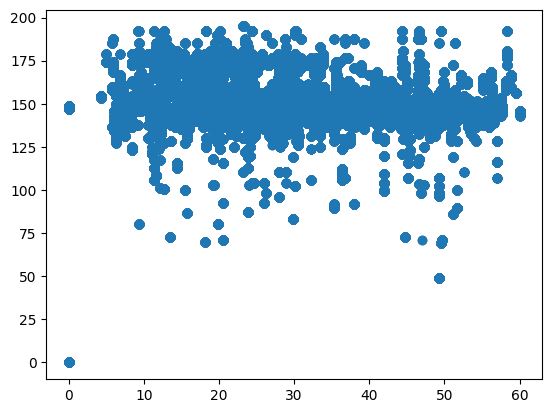

In [421]:
RESP_rrs_3 = pd.DataFrame(RESP_rrs_2).fillna(0).to_numpy().reshape(RESP_rrs_2.shape[0])
ECG_hrs_2 = pd.DataFrame(ECG_hrs_1).fillna(0).to_numpy().reshape(ECG_hrs_1.shape[0])
print(RESP_rrs_3.shape)
correlationTest(RESP_rrs_3[:],ECG_hrs_2[:])

In [426]:
# Linear Regression
SEED = 42
X = RESP_rrs_3.reshape(RESP_rrs_3.shape[0],1)
print(X.shape)
y = ECG_hrs_2.reshape(ECG_hrs_2.shape[0],1)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=SEED)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

(500000, 1)
(500000, 1)
X_train: (375000, 1), y_train: (375000, 1)
X_test: (125000, 1), y_test: (125000, 1)


In [428]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
print(regressor.intercept_)
print(regressor.coef_)

[159.45282]
[[-0.2564223]]


In [430]:
y_predict = regressor.predict(X_test)

In [432]:
mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse)
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 9.28
Mean squared error: 184.88
Root mean squared error: 13.60
